In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel, plot_loss_df
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System

In [2]:
pde_model = PDEModel("BruSan", {"num_epochs": 5000})
pde_model.set_state(["e", "z"], {"e": [0., 1.], "z": [0., 1.]})
pde_model.add_endogs(["q", "psi", "mue", "sigqk", "sigqs"], configs={
    "q": {"positive": True},
    "psi": {"positive": True},
    "mue": {"positive": True},
    "sigqk": {"positive": True},
    "sigqs": {"positive": True},
})
pde_model.add_agents(["vi", "vh"], configs={
    "vi": {"positive": True},
    "vh": {"positive": True},
})
pde_model.add_params({
    "gammai": 2,
    "gammah": 3,
    "ai": .1,
    "ah": .1,
    "rhoi": .04,
    "rhoh": .04,
    "sigz": .01,
    "sigbar": .5,
    "deltai": .04,
    "deltah": .04,
    "kappa_p": 2,
    "kappa_z": 5,
    "zetai": 1.15,
    "zetah": 1.15,
    "kappa_l": .9,
    "ebar": .5,
})

pde_model.add_equation("sigma = z")
pde_model.add_equation("wi = psi/e")
pde_model.add_equation("wh = (1-psi)/(1-e)")
pde_model.add_equation("ci = vi**((1-zetai)/(1-gammai))")
pde_model.add_equation("ch = vh**((1-zetah)/(1-gammah))")
pde_model.add_equation("iotai = (q-1)/kappa_p")
pde_model.add_equation("iotah = (q-1)/kappa_p")
pde_model.add_equation("phii = log(1+kappa_p*iotai)/kappa_p-deltai")
pde_model.add_equation("phih = log(1+kappa_p*iotah)/kappa_p-deltah")
pde_model.add_equation("muz = kappa_z*(sigbar-sigma)")
pde_model.add_equation("muk = psi*phii+(1-psi)*phih")
pde_model.add_equation("signis = wi*sigqs")
pde_model.add_equation("signhs = wh*sigqs")
pde_model.add_equation("signik = wi*(sigqk+sigma)")
pde_model.add_equation("signhk = wh*(sigqk+sigma)")
pde_model.add_equation("siges = e*(1-e)*(signis -sigqs)")
pde_model.add_equation("sigek = e*(1-e)*(signik - (sigqk+sigma))")
pde_model.add_equation("sigxik = vi_e/vi*sigek*e")
pde_model.add_equation("sigxhk = vh_e/vh*sigek*e")
pde_model.add_equation("sigxis = vi_e/vi*siges*e + vi_z/vi*sigz*z")
pde_model.add_equation("sigxhs = vh_e/vh*siges*e + vh_z/vh*sigz*z")
pde_model.add_equation("muq = q_e/q*mue*e + q_z/q*muz*z + 1/2*q_ee/q*((siges*e)**2 + (sigek*e)**2) + 1/2*q_zz/q*(sigz*z)**2 + q_ez/q*siges*e*sigz*z")
pde_model.add_equation("muri = (ai-iotai)/q + phii + muq + sigma*sigqk")
pde_model.add_equation("murh = (ah-iotah)/q + phih + muq + sigma*sigqk")
pde_model.add_equation("r = muri - gammai*wi*((sigqs**2)+(sigma+sigqk)**2) + sigqs*sigxis + (sigqk+sigma)*sigxik")
pde_model.add_equation("muni = r + wi*(muri-r)-ci")
pde_model.add_equation("munh = r + wh*(murh-r)-ch")

pde_model.add_endog_equation("kappa_l/e*(ebar-e)+(1-e)*(muni - muk - muq\
                     - sigma*sigqk + (sigqk+sigma)**2 + sigqs**2 \
                     - wi*sigqs**2 - wi*(sigqk+sigma)**2) - mue=0", weight=1.5)
pde_model.add_endog_equation("(ci*e+ch*(1-e))*q - psi*(ai-iotai) - (1-psi)*(ah-iotah)=0", weight=1.1)
pde_model.add_endog_equation("muri - murh + gammah*wh*((sigqs**2)+(sigqk+sigma)**2) - \
                     gammai*wi*((sigqs)**2+(sigqk+sigma)**2) + sigqs*sigxis + \
                     (sigqk+sigma)*sigxik - sigqs*sigxhs - (sigqk+sigma)*sigxhk=0", weight=2.0)
pde_model.add_endog_equation("(sigz*z*q_z + siges*e*q_e)-sigqs*q=0")
pde_model.add_endog_equation("sigek*e*q_e - sigqk*q=0")

print(pde_model)
pde_model.train_model("./models", "pymacrofin_2d2.pt", True)
if not os.path.exists("./models/pymacrofin_2d2.pt"):
    pde_model.train_model("./models", "pymacrofin_2d2.pt", True)
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/pymacrofin_2d2.pt"))
    pde_model.eval_model(True)

============================Summary of Model BruSan=============================
Config: {
 "batch_size": 100,
 "num_epochs": 5000,
 "lr": 0.001,
 "loss_log_interval": 100
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "gammai": 2,
 "gammah": 3,
 "ai": 0.1,
 "ah": 0.1,
 "rhoi": 0.04,
 "rhoh": 0.04,
 "sigz": 0.01,
 "sigbar": 0.5,
 "deltai": 0.04,
 "deltah": 0.04,
 "kappa_p": 2,
 "kappa_z": 5,
 "zetai": 1.15,
 "zetah": 1.15,
 "kappa_l": 0.9,
 "ebar": 0.5
}

================================State Variables=================================
e: [0.0, 1.0]
z: [0.0, 1.0]

=====================================Agents=====================================
Agent Name: vi
Agent(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3

Total loss: 1874.2965: 100%|██████████| 5000/5000 [09:46<00:00,  8.52it/s]        

training finished, total time :: 586.7201652526855
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 9.5972,
endogeq_2: 8.9346,
endogeq_3: 12.6693,
endogeq_4: 0.0012,
endogeq_5: 0.0367,
total_loss: 49.6003


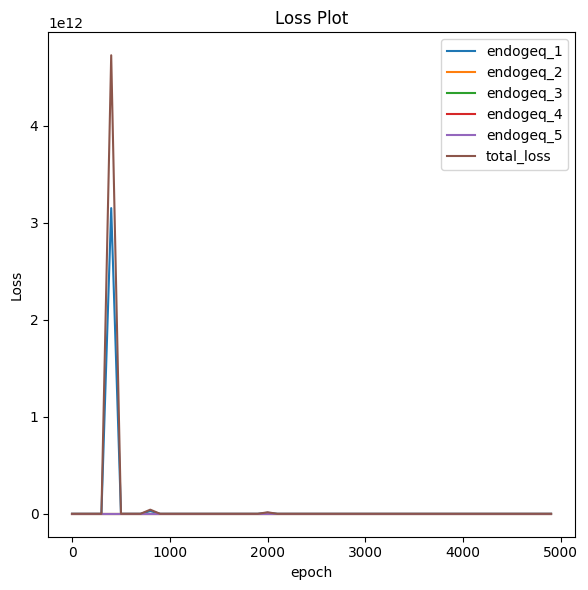

In [3]:
plot_loss_df(fn="./models/pymacrofin_2d2_loss.csv", loss_plot_fn="./models/pymacrofin_2d2_loss.png")

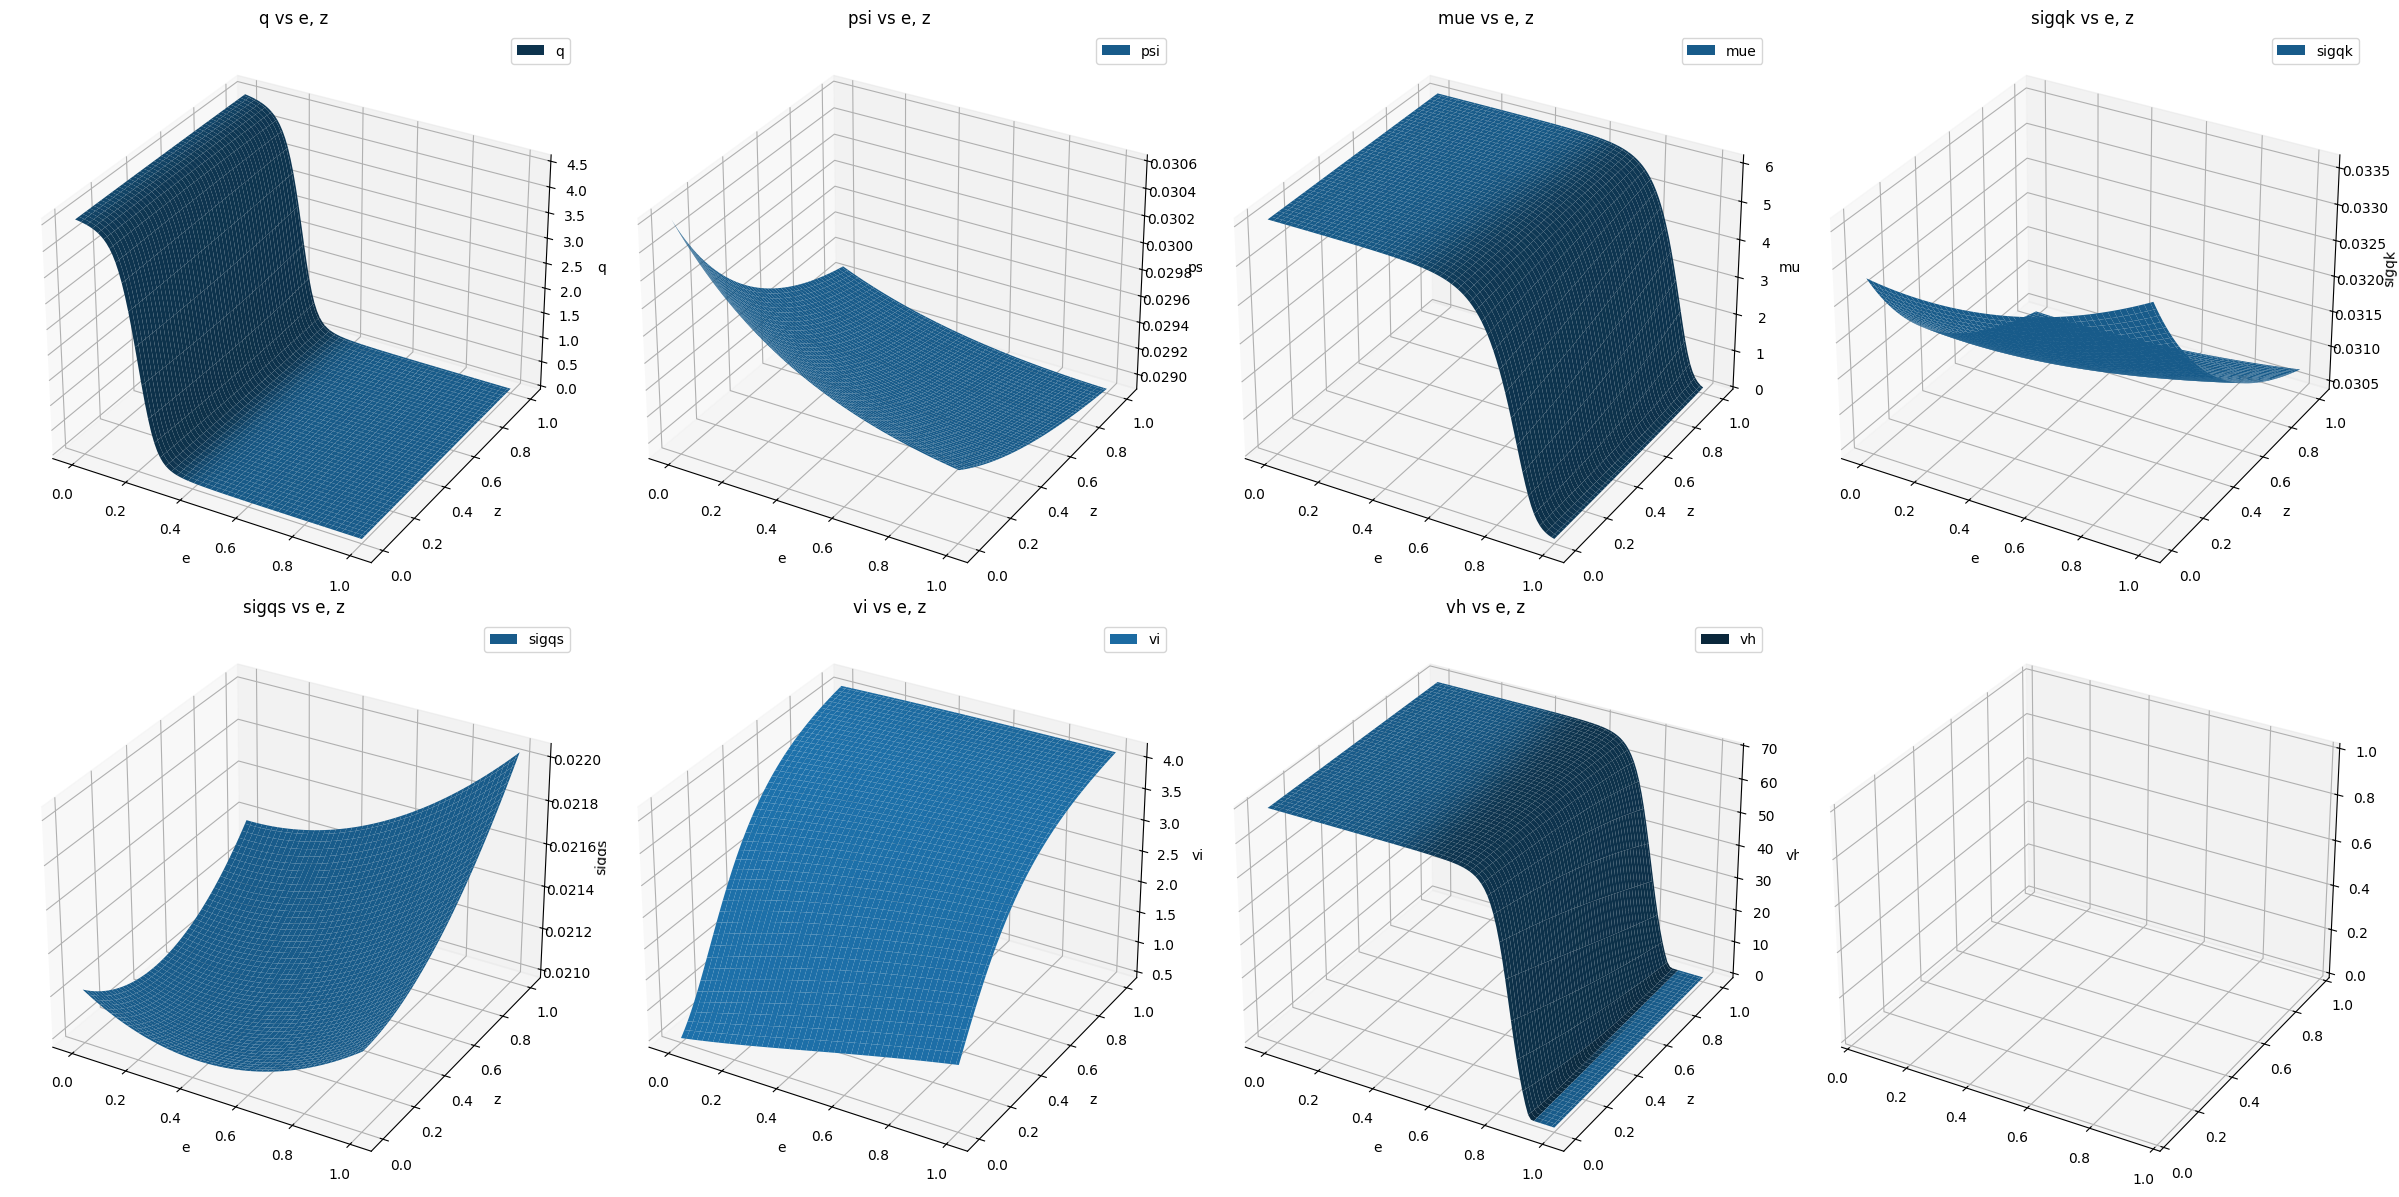

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12), subplot_kw={"projection": "3d"})
# "q", "psi", "mue", "sigqk", "sigqs"
pde_model.endog_vars["q"].plot("q", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][1])
pde_model.endog_vars["mue"].plot("mue", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][2])
pde_model.endog_vars["sigqk"].plot("sigqk", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][3])
pde_model.endog_vars["sigqs"].plot("sigqs", {"e": [0, 1], "z": [0, 1]}, ax=ax[1][0])
pde_model.agents["vi"].plot("vi", {"e": [0, 1], "z": [0, 1]}, ax=ax[1][1])
pde_model.agents["vh"].plot("vh", {"e": [0, 1], "z": [0, 1]}, ax=ax[1][2])
plt.tight_layout()
plt.show()